In [147]:
using CARMA
using CARMARVs
using HDF5
using PyCall
using PyPlot
using Ensemble
using Printf
using Statistics

corner = pyimport("corner")
sns = pyimport("seaborn")

PyPlot.svg(true)
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

In [3]:
post, ps, ns = CARMARVs.load_run("../K2-39b/runs/K2-39b.toml")

(CARMA.CARMAKepler.MultiEpochPosterior(Array{Float64,1}[[2.45723566962e6, 2.45723950242e6, 2.45723957252e6, 2.45723965383e6, 2.45724051866e6, 2.45724062475e6, 2.4572415516e6, 2.45724164591e6, 2.45724867838e6, 2.45724958312e6, 2.45726153317e6, 2.45726266662e6, 2.45734242953e6, 2.45734342036e6, 2.45734441133e6, 2.45739432683e6, 2.45739531999e6], [2.45725571433e6, 2.45725665992e6, 2.45725778349e6, 2.45725870438e6, 2.45726071027e6, 2.45727675557e6, 2.45727874939e6], [2.45725779909e6, 2.45725877452e6, 2.45726180523e6, 2.4572677024e6, 2.45726878307e6, 2.45726972528e6]], Array{Float64,1}[[24557.22, 24580.43, 24582.36, 24576.87, 24581.82, 24575.68, 24590.82, 24595.43, 24565.1, 24575.34, 24577.38, 24554.68, 24539.24, 24556.29, 24544.61, 24583.37, 24581.37], [24507.93, 24505.27, 24485.83, 24462.17, 24501.4, 24473.82, 24500.67], [0.73, -9.97, 0.0, -20.64, -5.45, 14.95]], Array{Float64,1}[[6.99, 5.65, 5.52, 6.13, 4.81, 5.84, 7.26, 5.24, 18.44, 6.52, 6.0, 7.26, 6.0, 9.07, 7.31, 5.6, 5.3], [2.66, 2.

In [7]:
nw = 128
nt = 16
nd = CARMA.CARMAKepler.nparams(post)

16

In [19]:
pts = CARMA.CARMAKepler.draw_prior(post, nw*nt)
pts = reshape(pts, (nd, nw, nt));

In [20]:
betas = reverse(collect(range(0, 1,length=nt)))
chain, chainloglike, chainlogprior, betas = EnsemblePTSampler.run_mcmc(pts, x -> CARMA.CARMAKepler.log_likelihood(post, x), x -> CARMA.CARMAKepler.log_prior(post, x), betas, 128);

In [124]:
s = 3
@time chain, chainloglike, chainlogprior, betas = EnsemblePTSampler.run_mcmc(reshape(chain[:,:,:,end], (nd, nw, nt)), x -> CARMA.CARMAKepler.log_likelihood(post, x), x -> CARMA.CARMAKepler.log_prior(post, x), betas, 1 << (11 + s), thin=1 << s);

798.488451 seconds (2.79 G allocations: 340.962 GiB, 7.76% gc time)


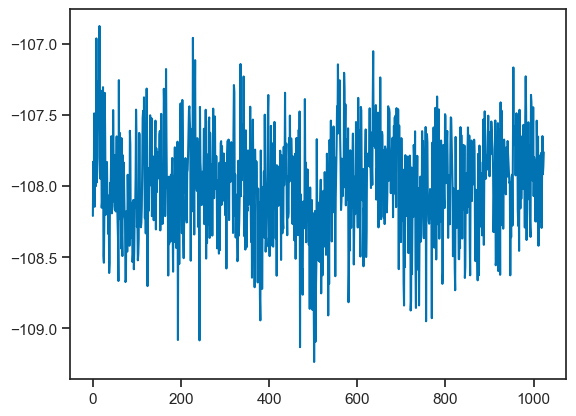

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1403e0da0>

In [125]:
plot(vec(mean(chainloglike[:, 1, :], dims=1)))

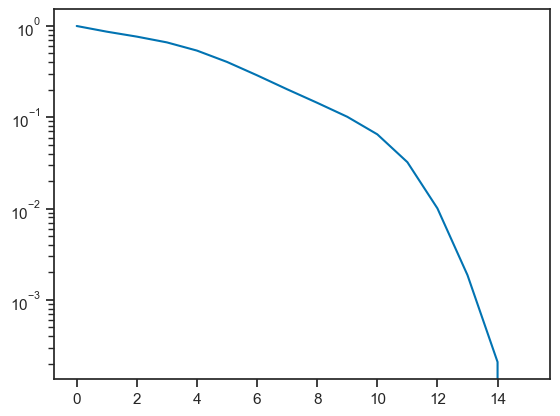

In [126]:
plot(betas)
yscale("log")

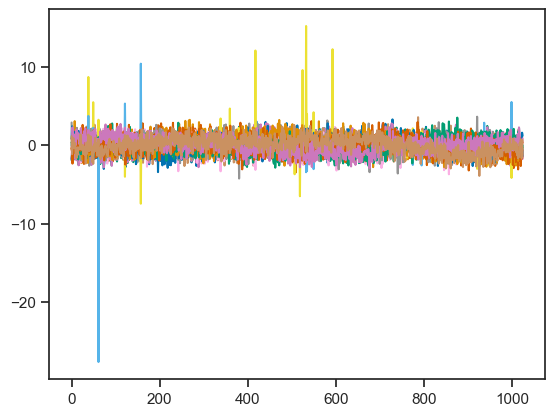

In [127]:
for i in 1:nd
    x = vec(mean(chain[i, :, 1, :], dims=1))
    plot((x .- mean(x))./std(x))
end

In [128]:
Acor.acl(chain[:,:,1,:])

16-element Array{Float64,1}:
 81.24209213529451  
 37.97290155144304  
 77.00203431777746  
 69.22507287380297  
 71.97601153469611  
  9.076030601657815 
  1.9330748484149063
  1.139992224435106 
  1.103901344271971 
  1.035904413605091 
 55.38823802349154  
 68.46701298701979  
 59.12089340314258  
 16.14425899478545  
 72.9582091743056   
 61.97517266369523  

In [129]:
acl_max = -Inf
t_max = 0
for t in 1:nt
    a = Acor.acl(chain[:,:,t,:])
    am = maximum(a)
    if am > acl_max
        acl_max = am
        t_max = t
    end
end
println("Max ACL is $(acl_max) at temp T[$(t_max)] = $(1.0/betas[t_max])")

Max ACL is 81.24209213529451 at temp T[1] = 1.0


In [130]:
ps_mcmc = CARMA.CARMAKepler.MultiEpochParams[]
nd, nw, nt, n = size(chain)
for i in 1:nw
    for j in 1:round(Int, acl_max):n
        push!(ps_mcmc, CARMA.CARMAKepler.to_params(post, chain[:,i,1,j]))
    end
end

In [131]:
drw_rms = [p.drw_rms for p in ps_mcmc]
if size(drw_rms[1], 1) == 1
    drw_rms = vcat(drw_rms...)
    drw_rms_label = [L"$A_\mathrm{drw}$"]
else
    drw_rms_label = [@sprintf("\$A_\\mathrm{drw}^{(%d)}\$", i) for i in 1:size(drw_rms[1],1)]
    drw_rms = hcat(drw_rms...)'
end

r_drw = [p.drw_rate for p in ps_mcmc]
if size(r_drw[1], 1) == 1
    r_drw = vcat(r_drw...)
    r_drw_label = [L"$r_\mathrm{drw}$"]
else
    r_drw_label = [@sprintf("\$r_\\mathrm{drw}^{(%d)}\$", i) for i in 1:size(r_drw[1], 1)]
    r_drw = hcat(r_drw...)'
end

osc_rms = [p.osc_rms for p in ps_mcmc]
if size(osc_rms[1],1) == 1
    osc_rms = vcat(osc_rms...)
    osc_rms_label = [L"$A_\mathrm{osc}$"]
else
    osc_rms_label = [@sprintf("\$A_\\mathrm{osc}^{(%d)}\$", i) for i in 1:size(osc_rms[1],1)]
    osc_rms = hcat(osc_rms...)'
end

osc_freq = [p.osc_freq for p in ps_mcmc]
if size(osc_freq[1],1) == 1
    osc_freq = vcat(osc_freq...)
    osc_freq_label = [L"$f$"]
else
    osc_freq_label = [@sprintf("\$f^{(%d)}\$", i) for i in 1:size(osc_freq[1],1)]
    osc_freq = hcat(osc_freq...)'
end

osc_Q = [p.osc_Q for p in ps_mcmc]
if size(osc_Q[1],1) == 1
    osc_Q = vcat(osc_Q...)
    osc_Q_label = [L"$Q$"]
else
    osc_Q_label = [@sprintf("\$Q^{(%d)}\$", i) for i in 1:size(osc_Q[1],1)]
    osc_Q = hcat(osc_Q...)'
end

1-element Array{LaTeXString,1}:
 L"$Q$"

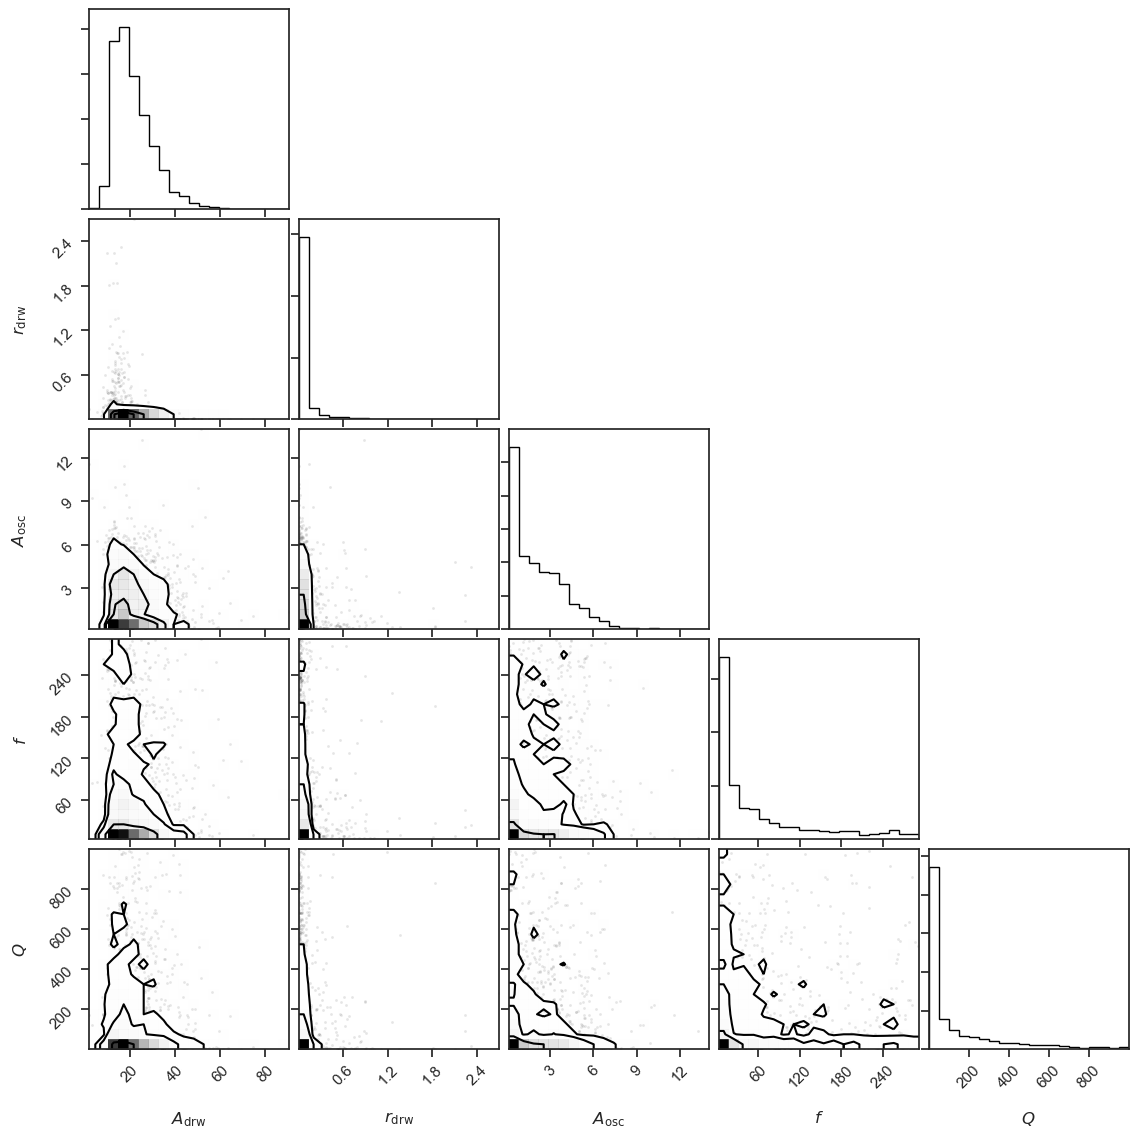

In [132]:
d = hcat(drw_rms, r_drw, osc_rms, osc_freq, osc_Q)
l = vcat(drw_rms_label, r_drw_label, osc_rms_label, osc_freq_label, osc_Q_label)
corner.corner(d, labels=l);

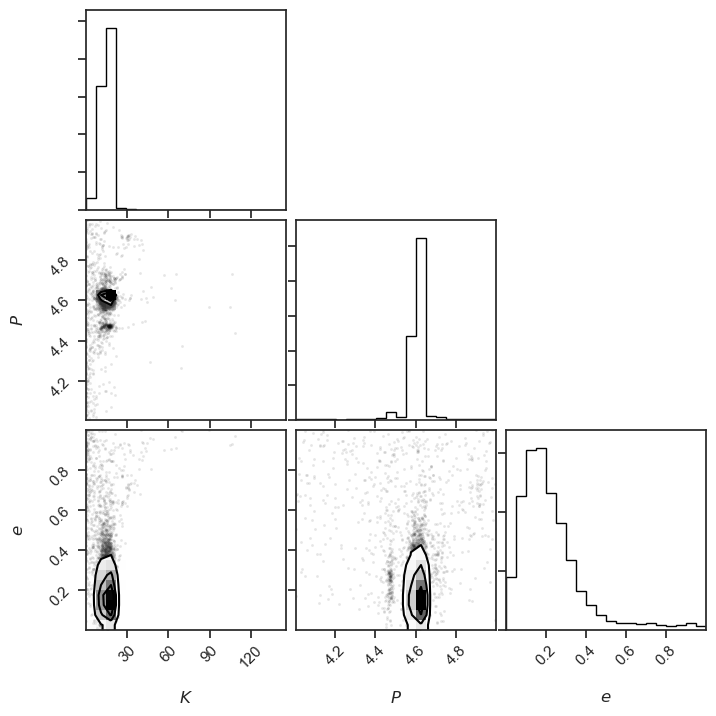

In [136]:
corner.corner(hcat([p.K for p in ps], [p.P for p in ps], [p.e for p in ps]),
              labels=[L"$K$", L"$P$", L"$e$"]);

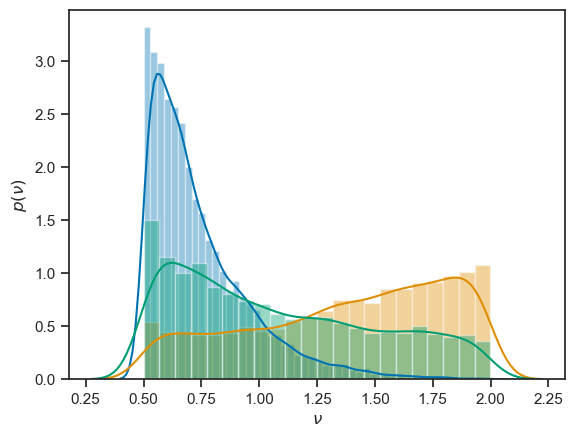

PyObject Text(29.0, 0.5, '$p\\left( \\nu \\right)$')

In [139]:
d = hcat([p.nu for p in ps]...)
for j in 1:size(d, 1)
    sns.distplot(vec(d[j, :]))
end
xlabel(L"$\nu$")
ylabel(L"$p\left( \nu \right)$")

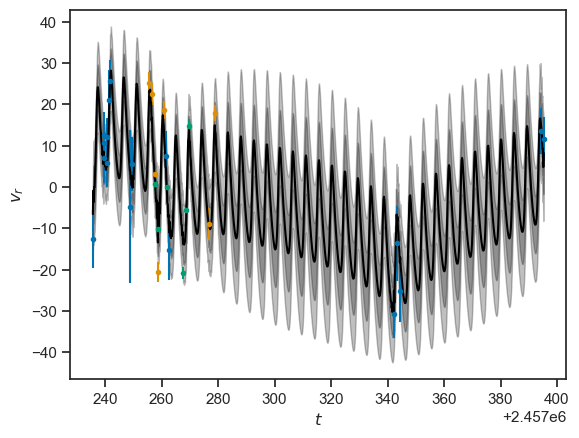

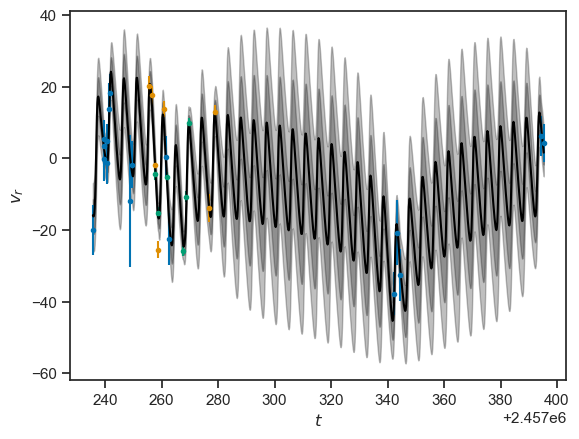

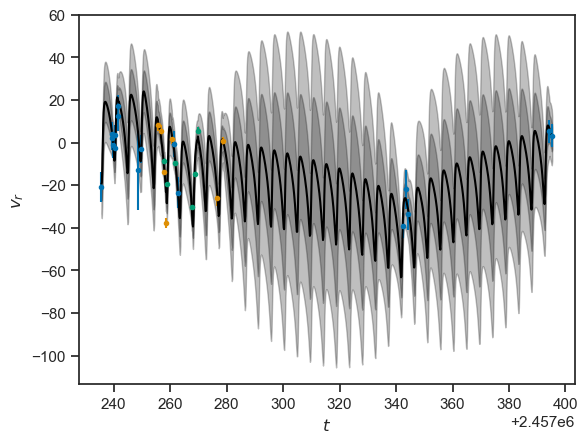

In [140]:
tmin = minimum([minimum(t) for t in post.ts])
tmax = maximum([maximum(t) for t in post.ts])
tpred = collect(range(tmin, stop=tmax, length=1000))
for draw in 1:3
    i = rand(1:size(ps,1))
    vp, vvp = CARMAKepler.predict(post, ps[i], tpred)

    figure()
    for (j, (t, v, dv)) in enumerate(zip(post.ts, post.ys, post.dys))
        errorbar(t, v .- ps[i].mu[j], dv, fmt=".")
    end

    plot(tpred, vp, "-k")
    fill_between(tpred, vp.+sqrt.(vvp), vp.-sqrt.(vvp), color="k", alpha=0.25)
    fill_between(tpred, vp.+ 2 .* sqrt.(vvp), vp.- 2 .* sqrt.(vvp), color="k", alpha=0.25)

    xlabel(L"$t$")
    ylabel(L"$v_r$")
end

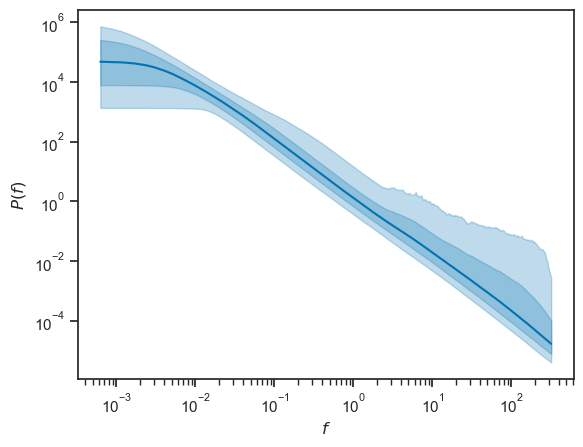

PyObject Text(28.0, 0.5, '$P(f)$')

In [141]:
T = tmax - tmin
df = 1.0/T
dt_min = minimum(diff(sort(vcat(post.ts...))))
fmax = 1.0/(2.0*dt_min)

fs = exp.(range(log(df/10.0), stop=log(fmax*10.0), length=1000))
psds = [CARMAKepler.psd(post, p, fs) for p in ps]

m = zeros(1000)
l = zeros(1000)
h = zeros(1000)
ll = zeros(1000)
hh = zeros(1000)

for i in 1:1000
    v = [p[i] for p in psds]
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    h[i] = quantile(v, 0.84)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
end

figure()
loglog(fs, m)
fill_between(fs, h, l, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs, hh, ll, color=sns.color_palette()[1], alpha=0.25)

xlabel(L"$f$")
ylabel(L"$P(f)$")

In [149]:
mkdir("../K2-39b/runs/mcmc")

"../K2-39b/runs/mcmc"

In [157]:
getproperty(ps_mcmc[1], Symbol("K"))

13.543979637247084

In [171]:
h5open("../K2-39b/runs/mcmc/state.h5", "w") do f
    mg = g_create(f, "mcmc_state")
    pg = g_create(f, "posterior")
    
    mg["chain", "shuffle", (), "compress", 3] = chain[:,:,:,end]
    mg["betas", "shuffle", (), "compress", 3] = betas
    
    for k in ["K", "P", "chi", "drw_rate", "drw_rms", "e", "mu", "nu", "omega", "osc_Q", "osc_freq", "osc_rms"]
        
        x = [getproperty(p, Symbol(k)) for p in ps_mcmc]
        if isa(x[1], Array)
            x = hcat(x...)
        end
        pg[k, "shuffle", (), "compress", 3] = x
    end
end;